In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.metrics import confusion_matrix

from sklearn.cluster import KMeans

import scipy.io #load .mat file

In [16]:
mat = scipy.io.loadmat("./MNist_ttt4275/data_all.mat")

#load
training_data = np.array(mat['trainv']).astype(float)
training_labels = np.array(mat['trainlab']).ravel()
test_data = np.array(mat['testv']).astype(float)
test_labels = np.array(mat['testlab']).ravel()

target_names = set(test_labels)

#shuffle
indexes = np.arange(len(training_data))
np.random.shuffle(indexes)

shuffled_training_data = training_data[indexes]
shuffled_training_labels = training_labels[indexes]

indexes = np.arange(len(test_data))
np.random.shuffle(indexes)

shuffled_test_data = test_data[indexes]
shuffled_test_labels = test_labels[indexes]

#extract subset
shuffled_training_data = shuffled_training_data[:1000]
shuffled_training_labels = shuffled_training_labels[:1000]
shuffled_test_data = shuffled_test_data[:1000]
shuffled_test_labels = shuffled_test_labels[:1000]

shuffled_training_data.shape

(1000, 784)

### Input normalization - Min-Max normalization

In [37]:
def min_max_normalize(data):
    """
    min-max normalize the elements of data.

    data: tensor with values to be normalized.
    """
    value_range = np.max(data) - np.min(data)
    normalized_data = (data - np.min(data))/value_range
     
    return normalized_data

#normalize training and test data
shuffled_training_data = min_max_normalize(shuffled_training_data)
shuffled_test_data = min_max_normalize(shuffled_test_data)
training_data = min_max_normalize(training_data)
test_data = min_max_normalize(test_data)



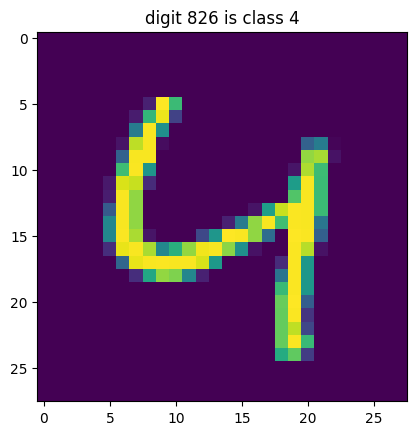

In [38]:
i = np.random.randint(0, len(shuffled_training_data))
plt.imshow(shuffled_training_data[i].reshape(28, 28))
plt.title(f'digit {i} is class {shuffled_training_labels[i]}')
plt.show()

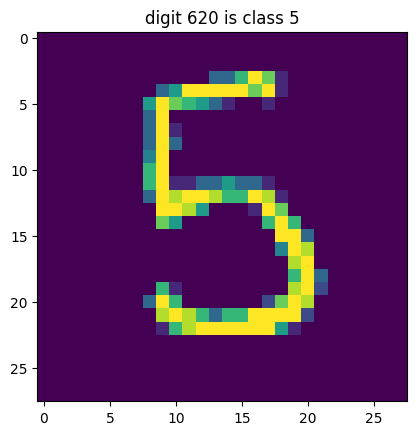

In [39]:
i = np.random.randint(0, len(shuffled_test_data))
plt.imshow(shuffled_test_data[i].reshape(28, 28))
plt.title(f'digit {i} is class {shuffled_test_labels[i]}')
plt.show()

In [40]:
def plot_confusion_matrix(conf_matrix, score = None, plot = True, filename = None):    
    plt.figure(figsize=(8, 8)) #size in inches
    sns.heatmap(conf_matrix, annot=True, fmt='g', linewidths=.5, square = True, cmap = 'Blues_r', xticklabels=target_names, yticklabels=target_names)
    plt.ylabel('Actual label', size=15)
    plt.xlabel('Predicted label', size=15)
    if score is not None:
        plt.title('Accuracy Score: {fscore:.{precision}f}%'.format(fscore = score*100, precision = 1), size = 20)
    if filename is not None:
        plt.savefig(filename)
    if plot:
        plt.show()
    plt.close()

In [41]:
class EuclidianKNearestNeighbor:
    def __init__(self, K = 1):

        if K%2 != 1:
            raise ValueError("K should be odd, so votes don't tie")
        
        self.K = K

    def fit(self, training_data, training_labels): #this corresponds to saving all images, along with their class
        self.data = training_data
        self.labels = training_labels

        self.N = len(self.labels)

    def predict(self, data):
        N = len(data)
        preds = np.zeros(N)

        for i in range(N):
            preds[i] = self.predict_one(data[i])

        return preds.astype(int)

    def predict_one(self, data):
        best_val = np.ones(self.K)*np.inf
        best_idx = -np.ones(self.K).astype(int)

        for i in range(self.N):
            d = self._distance(self.data[i], data)
            if d < np.max(best_val):
                ix = np.argmax(best_val) #replace highest value
                best_val[ix] = d
                best_idx[ix] = i

        labs = self.labels[best_idx]
        unique_labels, counts = np.unique(labs, return_counts=True)

        return unique_labels[np.argmax(counts)]
    

    def score(self, test_data, test_labels):
        N = len(test_labels)
        preds = self.predict(test_data)
        return 1 - np.count_nonzero(test_labels - preds)/N

    def _distance(self, a, b):
        return np.linalg.norm(a - b, 2)

In [42]:
classifier = EuclidianKNearestNeighbor(K = 1)

classifier.fit(shuffled_training_data, shuffled_training_labels)
score = classifier.score(shuffled_test_data, shuffled_test_labels)
preds = classifier.predict(shuffled_test_data)
conf_matrix = confusion_matrix(shuffled_test_labels, preds)

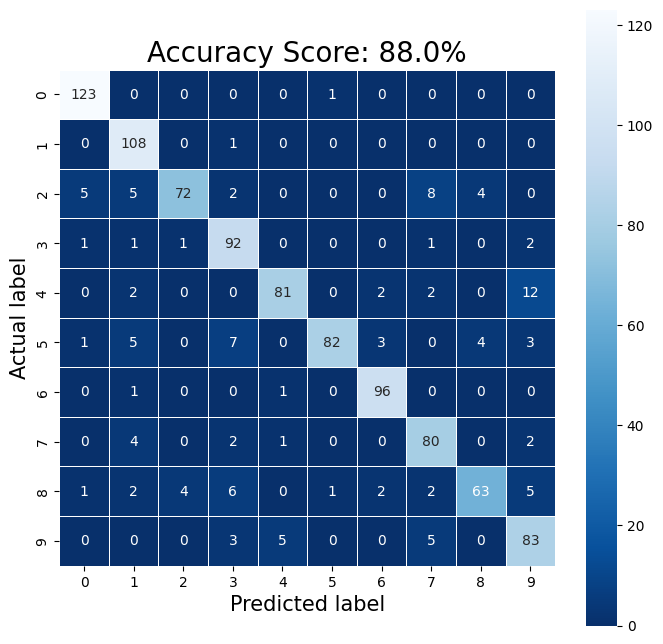

In [43]:
plot_confusion_matrix(conf_matrix, score)

### plot some wrong

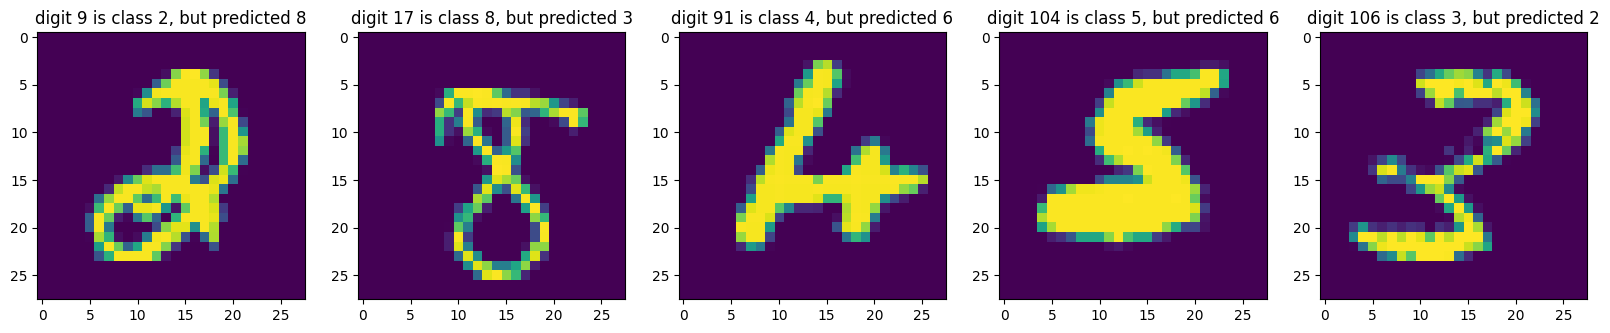

In [50]:
n = 5
fig, axs = plt.subplots(1, n)
fig.set_size_inches(20, 5)

error_idx = np.nonzero(preds - shuffled_test_labels)[0]

for i in range(n):
    ix = error_idx[i]
    axs[i].imshow(shuffled_test_data[ix].reshape(28, 28))
    axs[i].set_title(f'digit {ix} is class {shuffled_test_labels[ix]}, but predicted {preds[ix]}')

plt.show()

### plot some right

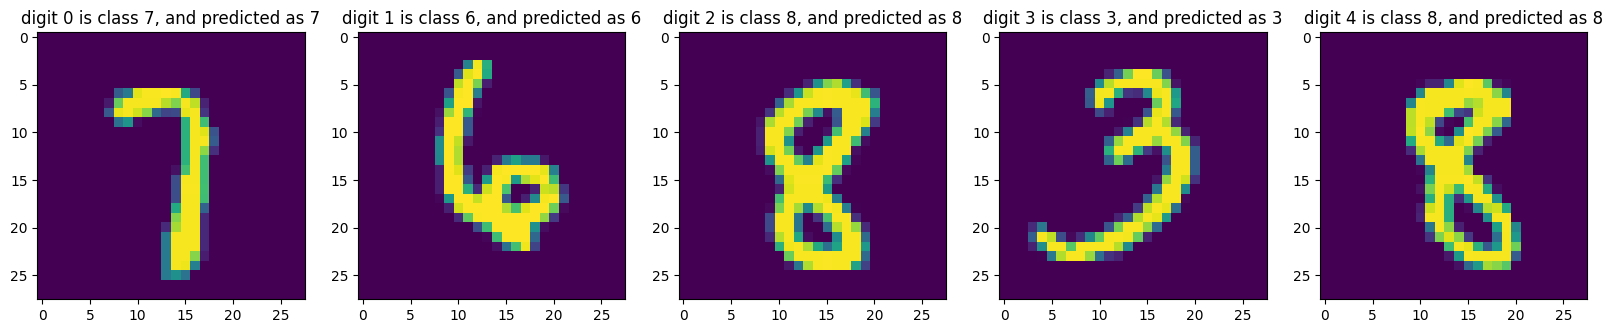

In [51]:
n = 5
fig, axs = plt.subplots(1, n)
fig.set_size_inches(20, 5)

error = preds - shuffled_test_labels
right_idx = np.where(error == 0)[0]

for i in range(n):
    ix = right_idx[i]
    axs[i].imshow(shuffled_test_data[ix].reshape(28, 28))
    axs[i].set_title(f'digit {ix} is class {shuffled_test_labels[ix]}, and predicted as {preds[ix]}')

plt.show()

## Part 2

In [52]:
M = 64 #num clusters, per class

templates = np.zeros((10, M, 28*28))

for i in range(10):
    templates[i] = KMeans(n_clusters = M, n_init='auto').fit(training_data[training_labels == i]).cluster_centers_

In [53]:
templates = templates.reshape(10*M, 28*28)
template_labels = np.tile(np.arange(10), M).reshape(M, 10).T.flatten() #should be a better way to do this, but this works

indexes = np.arange(10*M)
np.random.shuffle(indexes)

templates = templates[indexes]
template_labels = template_labels[indexes]

In [54]:
classifier = EuclidianKNearestNeighbor(K = 1)

classifier.fit(templates, template_labels)
score = classifier.score(shuffled_test_data, shuffled_test_labels)
preds = classifier.predict(shuffled_test_data)
conf_matrix = confusion_matrix(shuffled_test_labels, preds)

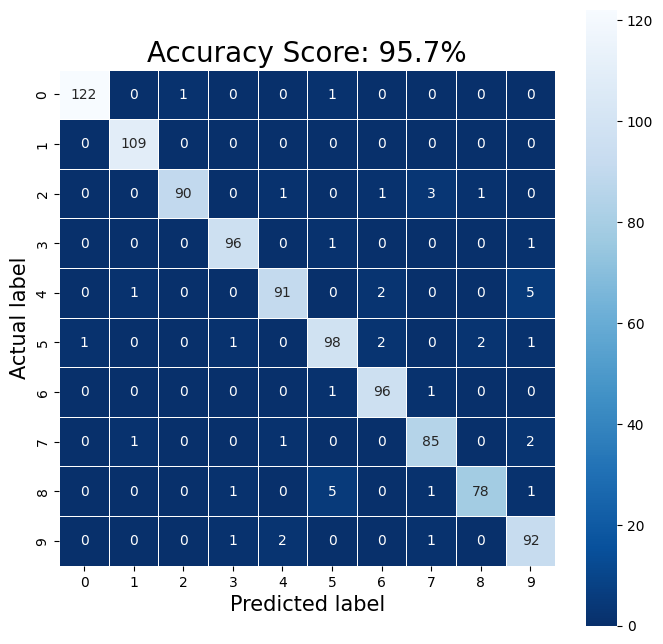

In [55]:
plot_confusion_matrix(conf_matrix, score)

### plot some wrong

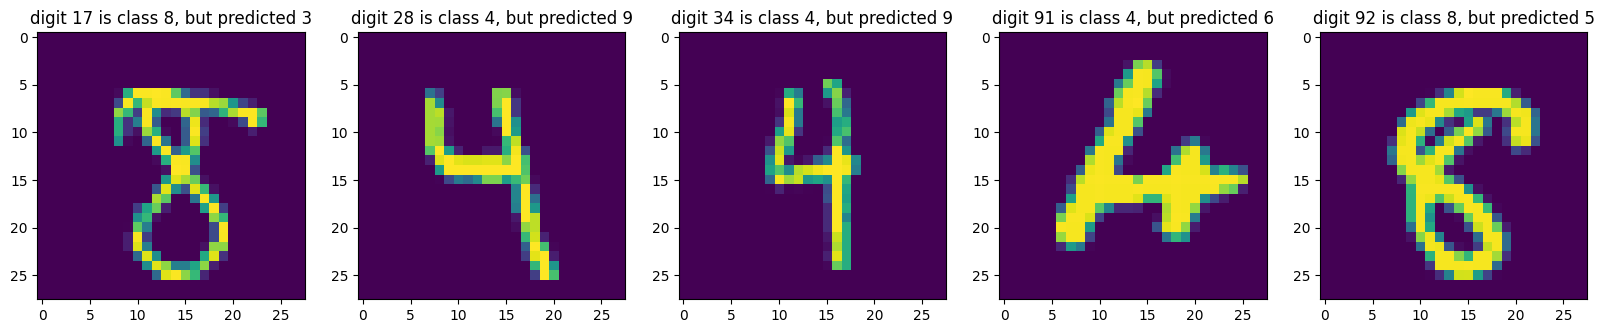

In [56]:
n = 5
fig, axs = plt.subplots(1, n)
fig.set_size_inches(20, 5)

error_idx = np.nonzero(preds - shuffled_test_labels)[0]

for i in range(n):
    ix = error_idx[i]
    axs[i].imshow(shuffled_test_data[ix].reshape(28, 28))
    axs[i].set_title(f'digit {ix} is class {shuffled_test_labels[ix]}, but predicted {preds[ix]}')

plt.show()

### K = 7 nearest neighbour

In [57]:
classifier = EuclidianKNearestNeighbor(K = 7)

classifier.fit(templates, template_labels)
score = classifier.score(shuffled_test_data, shuffled_test_labels)
preds = classifier.predict(shuffled_test_data)
conf_matrix = confusion_matrix(shuffled_test_labels, preds)

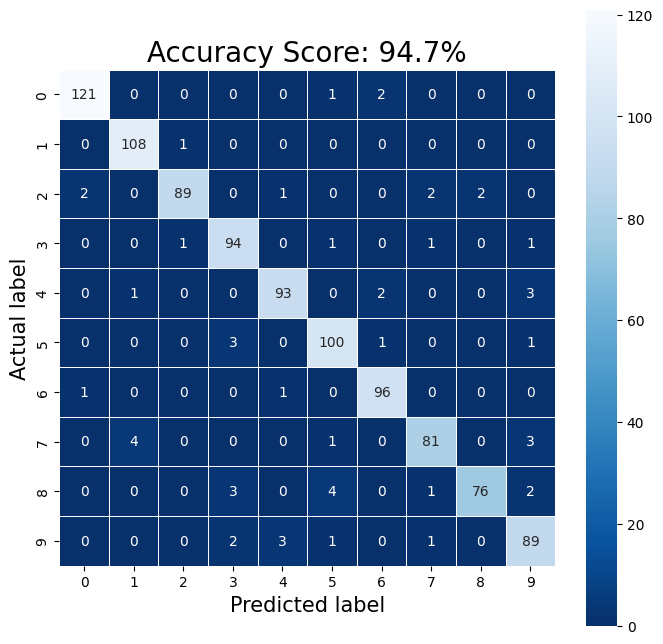

In [58]:
plot_confusion_matrix(conf_matrix, score)

### Plot some wrong

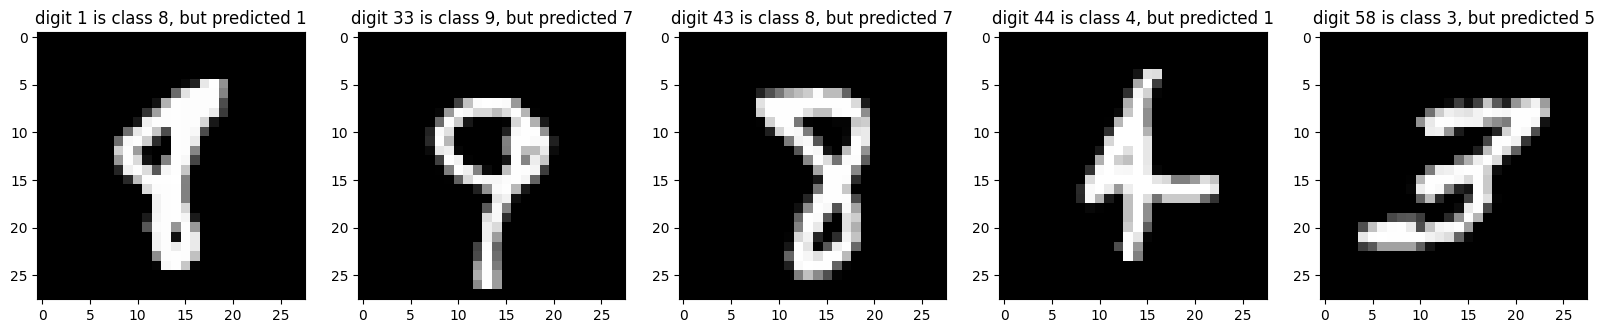

In [416]:
n = 5
fig, axs = plt.subplots(1, n)
fig.set_size_inches(20, 5)

error_idx = np.nonzero(preds - shuffled_test_labels)[0]

for i in range(n):
    ix = error_idx[i]
    axs[i].imshow(shuffled_test_data[ix].reshape(28, 28))
    axs[i].set_title(f'digit {ix} is class {shuffled_test_labels[ix]}, but predicted {preds[ix]}')

plt.show()